<h2 style="background-color:orange;color:black">Evolution</h2>
This notebook is aimed at exploring time evolution. Not the Darwinian kind, the quantum kind. <br>
The time evolution operator in quantum mechanics is given by,
\begin{align}
\hat U(0,t) = \mathcal T \exp\left(-\frac{i}{\hbar}\int_0^t H(\tau)d\tau\right)
\end{align}
In the Schrodinger picure, the operator acts on a state to evolve it from time $0$ to time $t$. In the Heisenberg picture, the states are constant in time, while the operators evolve in time. The problem with this operator is that it involves time ordred integrals, which is not easy numerically. We can look at two approaches:<br>
<li>Calculate time ordered expnentials using Magnus expansion.</li> 
<li>Dyson series<li>
<li>Abandon evolution operator and solve the Schrodinger equation using Crank-Nicolson or RK4</li> 
<h3>Magnus expansion</h3>    
\begin{align}
    U(t) &= \exp\left( \Omega(t) \right) \\
    \Omega(t) &= \Omega_1(t) + \Omega_2(t) + \Omega_3(t) + \cdots \\
    \Omega_1(t) &= -i \int_0^t H(\tau_1)\, d\tau_1 \\
    \Omega_2(t) &= -\frac{1}{2} \int_0^t d\tau_1 \int_0^{\tau_1} d\tau_2 \, [H(\tau_1), H(\tau_2)] \\
    \Omega_3(t) &= \frac{i}{6} \int_0^t d\tau_1 \int_0^{\tau_1} d\tau_2 \int_0^{\tau_2} d\tau_3 \, \Big( [H(\tau_1),[H(\tau_2),H(\tau_3)]] + [H(\tau_3), [H(\tau_2), H(\tau_1)]] \Big)
\end{align}

<h3>RK4 method</h3>
To solve $\frac{dy}{dx} = f(x, y)$:
\begin{align}
    y_{i+1} &= y_i + \frac{1}{6}(k_1 + 2k_2 +2k_3 + k_4)h\\
    k_1 &= f(x_i, y_i)\\
    k_2 &= f(x_i + \frac{1}{2}h, y_i + \frac{1}{2}k_1h)\\
    k_3 &= f(x_i + \frac{1}{2}h, y_i + \frac{1}{2}k_2h)\\
    k_4 &= f(x_i + h, y_i + k_3h)
\end{align}
<h3>Dyson series</h3>
\begin{align}
    U(t, t_0) = \mathbb I + \sum_{n=1}^\infty (-\frac{i}{\hbar})^n \int_{t_0}^t dt_1 \int_{t_0}^{t_1}dt_2\dots\int_{t_0}^{t_{n-1}}dt_n H(t_1)H(t_2)H(t_3) \dots H(t_n)
\end{align}
Let's try it out!

<H3>Dyson Series</H3>

In [6]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy.linalg import expm
import scipy.integrate as integrate

In [15]:
def simpson1(f, a, b):
    res = f(a) + f(b) + 4*f((a+b)/2)
    return (b-a)*res/6
def simpson2(g, a, b, c, d): # a and b are x limits. c and d are y limits
    hx, hy = b - a, d - c
    t1 = g(a, c) + g(b, c) + g(a, d) + g(b, d)
    t2 = g((a+b)/2, c) + g((a+b)/2, d) + g(a, (c+d)/2) + g(b, (c+d)/2)
    t3 = g((a+b)/2, (c+d)/2)
    return hx*hy*(t1 + 4*t2 + 16*t3)/36    

In [17]:
sigmax = np.matrix([[0, 1],[1, 0]], dtype=complex)
sigmay = np.matrix([[0, -1j],[1j, 0]], dtype=complex)
sigmaz = np.matrix([[1, 0j],[0, -1]], dtype=complex)
w1 = 0.1
g = np.sqrt(2)
w2 = g*w1
m = 1
phi1 = np.pi/10
phi2 = 0

def H(w1, phi1, w2, phi2, m, t):
    return (np.sin(w1*t + phi1)*sigmax + np.sin(w2*t + phi2)*sigmay + (m - np.cos(w1*t + phi1) - np.cos(w2*t + phi2))*sigmaz)


In [19]:
h1 = lambda t: H(w1, phi1, w2, phi2, m, t)
h2 = lambda t1, t2: H(w1, phi1, w2, phi2, m, t1) @ H(w1, phi1, w2, phi2, m, t2)
h0 = np.matrix(np.eye(2, dtype=complex))

def U(t):
    t1 = simpson1(h1, 0, t)
    t2 = simpson2(h2, 0, t, 0, t/3)
    return h0 - (1j)*t1 - (1j)*t2

Now that the evolution operator is defined using the dyson series (upto the second order), we proceed to the next step of using it in the quasi-energy derivation.

In [24]:
def eigv1(w1, phi1, w2, phi2, m, t):
    d1 = np.sin(w1*t + phi1)
    d2 = np.sin(w1*t + phi1)
    d3 = (m - np.cos(w1*t + phi1) - np.cos(w2*t + phi2))
    d = np.sqrt(d1**2 + d2**2 + d3**2)
    return (1/(np.sqrt(2*d*(d+d3))))*np.matrix([[d1 - 1j * d2], [d + d3]])

phi1vals = np.arange(-np.pi, 50*np.pi, 0.1)
phi2 = 0
phi1 = np.pi/10
dt = 0.1

e1_theta = []
e2_theta = []
for i in phi1vals:
    u =  U(dt)
    expE_i = eigv1(w1, i - w1*dt, w2, phi2 - w2*dt, m, 0).H @ u @  eigv1(w1, i, w2, phi2, m, 0)
    e1_theta.append(np.angle(expE_i[0,0])/dt)
    e2_theta.append(-np.angle(expE_i[0,0])/dt)

[]

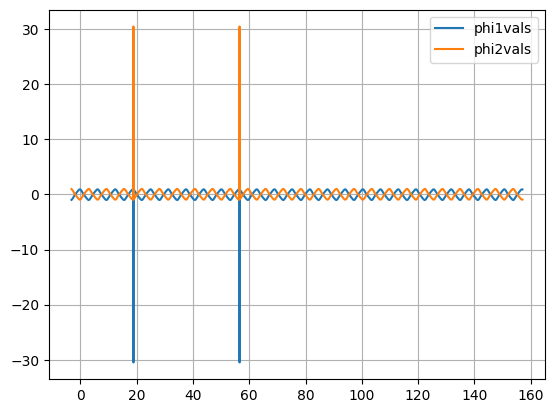

In [26]:
plt.plot(phi1vals, e1_theta)
plt.plot(phi1vals, e2_theta)
plt.legend(['phi1vals', 'phi2vals'])
plt.grid()
plt.plot()

<H2>RK4</H2>

In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy.linalg import expm
import scipy.integrate as integrate

sigmax = np.matrix([[0, 1],[1, 0]])
sigmay = np.matrix([[0, -1j],[1j, 0]])
sigmaz = np.matrix([[1, 0j],[0, -1]])


def H(w1, phi1, w2, phi2, m, t):
    return (np.sin(w1*t + phi1)*sigmax + np.sin(w2*t + phi2)*sigmay + (m - np.cos(w1*t + phi1) - np.cos(w2*t + phi2))*sigmaz)

def eigv1(w1, phi1, w2, phi2, m, t):
    d1 = np.sin(w1*t + phi1)
    d2 = np.sin(w1*t + phi1)
    d3 = (m - np.cos(w1*t + phi1) - np.cos(w2*t + phi2))
    d = np.sqrt(d1**2 + d2**2 + d3**2)
    return (1/(np.sqrt(2*d*(d+d3))))*np.matrix([[d1 - 1j * d2], [d + d3]])
    
def rk4step(t0, h):
    v = eigv1(w1, phi1, w2, phi2, m, t0)
    k1 = -1j * H(w1, phi1, w2, phi2, m, t0) @ v
    k2 = -1j * H(w1, phi1, w2, phi2, m, t0 + h/2) @ (v + k1*h/2)
    k3 = -1j * H(w1, phi1, w2, phi2, m, t0 + h/2) @(v + k2*h/2)
    k4 = -1j * H(w1, phi1, w2, phi2, m, t0 + h) @ (v + k3*h)
    return v + (h/6)*(k1 + 2*k2 + 2*k3 + k4)

In [2]:
w1 = 0.1
g = np.sqrt(2)
w2 = g*w1
m = 1
phi1 = np.pi/10
phi2 = 0

In [37]:
h = 0.1
ti = 0
band1 = []
band2 = []
tvals = []
while(ti<1e4):
    v1 = eigv1(w1, phi1, w2, phi2, m, ti)
    v2 = np.conjugate(v1)
    e1 = v1.H @ H(w1, phi1, w2, phi2, m, ti) @ v1
    e2 = v2.H @ H(w1, phi1, w2, phi2, m, ti) @ v2
    band1.append(np.real(e1[0,0]))
    band2.append(np.real(e2[0,0]))
    tvals.append(ti)
    ti = ti + h